<b><h1>Portfolio Optimization</h1></b>

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import plotly.express as px
import plotly.graph_objects as go
import scipy.optimize as sco
import scipy.interpolate as sci



In [2]:
start = datetime.datetime(2021, 1,1)
end = datetime.datetime(2022, 10, 1)
symbols = ["BTC-USD" ,"ETH-USD", "SOL-USD", "MATIC-USD", "DOT-USD", "AVAX-USD", "NEAR-USD", "LINK-USD", "BNB-USD", "ATOM-USD"]
#symbols = ["GC=F", "SI=F"]
#symbols = ['INFY.NS', 'WIPRO.NS', 'TCS.NS', 'MINDTREE.NS', 'HCLTECH.NS']
number_of_assets = len(symbols)

In [3]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = pdr.DataReader(sym, data_source='yahoo', start=start, end=end)['Adj Close']
data.columns = symbols

<h3>Normalized Price<h3>

In [4]:
px.line(data / data.abs().max() * 100)

<h3>Returns<h3>

In [5]:
returns = np.log(data / data.shift(1))
returns.mean() * 365

BTC-USD     -0.232265
ETH-USD      0.328648
SOL-USD      1.752225
MATIC-USD    2.154160
DOT-USD     -0.224525
AVAX-USD     0.964579
NEAR-USD     0.534564
LINK-USD    -0.241282
BNB-USD      1.156099
ATOM-USD     0.382290
dtype: float64

<h3>Covariance matrix for the assets to be invested<h3>
The covariance matrix for the assets to be invested in is the central piece of the whole portfolio selection process. pandas has a built-in method to generate the covariance matrix:

In [6]:
returns.cov() * 365

,BTC-USD,ETH-USD,SOL-USD,MATIC-USD,DOT-USD,AVAX-USD,NEAR-USD,LINK-USD,BNB-USD,ATOM-USD
BTC-USD,0.564622,0.613689,0.567354,0.722274,0.698181,0.678844,0.641206,0.679082,0.587643,0.641715
ETH-USD,0.613689,1.005686,0.889040,1.070276,0.995444,0.957975,0.916534,1.007235,0.802372,0.930912
SOL-USD,0.567354,0.889040,2.042675,1.201059,1.032711,1.261590,1.152242,1.019426,0.964507,1.035499
MATIC-USD,0.722274,1.070276,1.201059,2.591953,1.285776,1.470176,1.279775,1.325505,1.196773,1.342785
DOT-USD,0.698181,0.995444,1.032711,1.285776,1.667027,1.274492,1.202481,1.256587,0.976901,1.299243
AVAX-USD,0.678844,0.957975,1.261590,1.470176,1.274492,2.434665,1.334694,1.190558,1.079498,1.363873
NEAR-USD,0.641206,0.916534,1.152242,1.279775,1.202481,1.334694,2.314581,1.161479,0.913847,1.346938
LINK-USD,0.679082,1.007235,1.019426,1.325505,1.256587,1.190558,1.161479,1.598653,0.973294,1.256917
BNB-USD,0.587643,0.802372,0.964507,1.196773,0.976901,1.079498,0.913847,0.973294,1.356275,0.941201
ATOM-USD,0.641715,0.930912,1.035499,1.342785,1.299243,1.363873,1.346938,1.256917,0.941201,2.068349


<h3>wealth has to be divided among the available assets in such a way that all positions are long (positive) and that the positions add up to 100%.

𝚺Iwi = 1, where I is the number of assets and wi ≥ 0 is the weight of asset i.
General formula for expected portfolio return

<b>𝜇p = E(𝚺Iwiri)</b>

=> 𝚺IwiE(ri)
=> 𝚺Iwi𝜇i
=> w^T𝜇

ri are the state- dependent future returns (vector with return values assumed to be normally distribut‐ ed) and 𝜇i is the expected return for security i.
Finally, wT is the transpose of the weights vector and 𝜇 is the vector of the expected security returns
</h3>

In [7]:
weights = np.random.random(number_of_assets)
weights /= np.sum(weights)

expected_portfolio_returns = np.sum(returns.mean() * weights) * 365

<h3>The second object of choice in MPT is the expected portfolio variance.
The covariance between two securities is defined by 𝜎ij = 𝜎ji = E(ri – 𝜇i)(rj – 𝜇j)).</h3>



In [8]:
expected_portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 365, weights))
expected_portfolio_variance

1.2588281023162835

<h3>The (expected) portfolio standard deviation or volatility σ p = σ 2p is then only one square root away:</h3>


In [9]:
expected_portfolio_sd_or_volatility =  np.sqrt(expected_portfolio_variance)
expected_portfolio_sd_or_volatility

1.1219750898822503

<h3>we implement a Monte Carlo simulation to generate random portfolio weight vectors on a larger scale. For every simulated allocation, we record the resulting expected portfolio return and variance</h3>

In [10]:
portfolio_returns = []
portfolio_volatility = []

for p in range(2500):
    weights = np.random.random(number_of_assets)
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(returns.mean() * weights) * 365)
    portfolio_volatility.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 365, weights))))

portfolio_returns = np.array(portfolio_returns)
portfolio_volatility = np.array(portfolio_volatility)

fig = go.Figure(px.scatter(x=portfolio_volatility, y=portfolio_returns, color=portfolio_returns/portfolio_volatility, labels={'x':'expected volatality', 'y': 'expected return', 'color': 'Sharpe ratio'}))
fig.show()

<h3>Portfolio Optimizations</h3><br>
<h4>To make our lives a bit easier, first we have a convenience function giving back the major portfolio statistics for an input weights vector/array:</h4>


In [11]:
def statistics(weights):
    ''' Returns portfolio statistics.
                    Parameters
                    ==========
                    weights : array-like
                        weights for different securities in portfolio
                    Returns
                    =======
                    pret : float
                        expected portfolio return
                    pvol : float
                        expected portfolio volatility
                    pret / pvol : float
                        Sharpe ratio for rf=0
                    '''
    weights = np.array(weights)
    pret = np.sum(returns.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))) 
    return np.array([pret, pvol, pret / pvol])

<h3>
The minimization function minimize is quite general and allows for (in)equality con‐ straints and bounds for the parameters. Let us start with the maximization of the Sharpe ratio. Formally, we minimize the negative value of the Sharpe ratio:
</h3>

In [12]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [13]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(number_of_assets))
number_of_assets * [ 1. / number_of_assets]


[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [14]:
%%time

opts = sco.minimize(min_func_sharpe, number_of_assets * [ 1. / number_of_assets], method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 50.7 ms, sys: 1.31 ms, total: 52 ms
Wall time: 50.9 ms


In [15]:
opts

     fun: -1.2248214286901178
     jac: array([ 5.91325134e-01,  4.72977653e-01,  8.02665949e-04, -6.86079264e-04,
        9.42311719e-01,  3.43265191e-01,  5.05697757e-01,  9.63238075e-01,
        2.89385617e-02,  5.86809799e-01])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([6.83114477e-17, 0.00000000e+00, 4.59834078e-01, 5.40165922e-01,
       0.00000000e+00, 2.32859757e-17, 0.00000000e+00, 1.65571714e-16,
       0.00000000e+00, 0.00000000e+00])

<h3>Our main interest lies in getting the optimal portfolio composition. To this end, we access the results object by providing the key of interest—i.e., x in our case</h3>

In [16]:
opts['x'].round(3)

array([0.  , 0.  , 0.46, 0.54, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

<h3>Using the portfolio weights from the optimization, the following statistics emerge:</h3>

In [17]:
statistics(opts['x']).round(3)

array([1.36 , 1.11 , 1.225])

<h3>

The expected return is about 100%, the expected volatility is about 110%, and the resulting optimal Sharpe ratio is 0.913.
</h3>

<h3>

Next, let us minimize the variance of the portfolio. This is the same as minimizing the volatility, but we will define a function to minimize the variance:
</h3>

In [18]:
def min_func_variance(weights): return statistics(weights)[1] ** 2

In [19]:
optv = sco.minimize(min_func_variance, number_of_assets * [1. / number_of_assets,], method='SLSQP', bounds=bnds,constraints=cons)
optv

     fun: 0.38982127336670974
     jac: array([0.77964254, 0.84739555, 0.7834152 , 0.99733159, 0.96406343,
       0.93736289, 0.88539074, 0.93769184, 0.81143064, 0.88609483])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.00000000e+00, 0.00000000e+00, 1.66533454e-16, 0.00000000e+00,
       6.93889390e-18, 2.08166817e-17, 6.93889390e-18, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [20]:
optv['x'].round(3)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
statistics(optv['x']).round()

array([-0.,  1., -0.])

<h3>

<b>Efficient Frontier</b>
The derivation of all optimal portfolios—i.e., all portfolios with minimum volatility for a given target return level (or all portfolios with maximum return for a given risk level) —is similar to the previous optimizations. The only difference is that we have to iterate over multiple starting conditions. The approach we take is that we fix a target return level and derive for each such level those portfolio weights that lead to the minimum volatility value. For the optimization, this leads to two conditions: one for the target return level tret and one for the sum of the portfolio weights as before. The boundary values for each parameter stay the same:


</h3>

In [22]:
def min_func_port(weights): return statistics(weights)[1]


In [23]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, number_of_assets * [1. / number_of_assets,], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)


CPU times: user 7.91 s, sys: 36.5 ms, total: 7.95 s
Wall time: 7.99 s


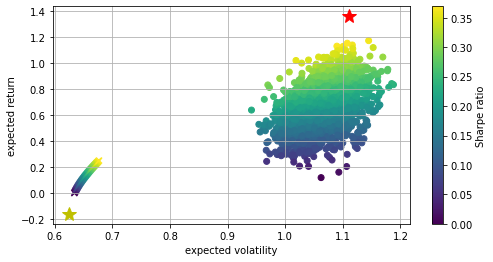

In [24]:
plt.figure(figsize=(8, 4))
plt.scatter(portfolio_volatility, portfolio_returns, c=portfolio_returns / portfolio_volatility, marker='o')
# random portfolio composition
plt.scatter(tvols, trets, c=trets / tvols, marker='x')
# efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

Capital Market Line
In addition to risky securities like stocks or commodities (such as gold), there is in general one universal, riskless investment opportunity available: cash or cash accounts. In an idealized world, money held in a cash account with a large bank can be considered riskless (e.g., through public deposit insurance schemes). The downside is that such a riskless investment generally yields only a small return, sometimes close to zero.
However, taking into account such a riskless asset enhances the efficient investment opportunity set for investors considerably. The basic idea is that investors first determine an efficient portfolio of risky assets and then add the riskless asset to the mix. By ad‐ justing the proportion of the investor’s wealth to be invested in the riskless asset it is possible to achieve any risk-return profile that lies on the straight line (in the risk-return space) between the riskless asset and the efficient portfolio.
Which efficient portfolio (out of the many options) is to be taken to invest in optimal fashion? It is the one portfolio where the tangent line of the efficient frontier goes exactly through the risk-return point of the riskless portfolio. For example, consider a riskless interest rate of rf = 0.01. We look for that portfolio on the efficient frontier for which the tangent goes through the point (𝜎f,rf) = (0,0.01) in risk-return space.
For the calculations to follow, we need a functional approximation and the first deriv‐ ative for the efficient frontier. We use cubic splines interpolation to this end

In [25]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [26]:
tck = sci.splrep(evols, erets)

In [27]:
def f(x):
    ''' Efficient frontier function (splines approximation). ''' 
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. ''' 
    return sci.splev(x, tck, der=1)


What we are looking for is a function t(x) = a + b · x describing the line that passes through the riskless asset in risk-return space and that is tangent to the efficient frontier. Equation 11-4 describes all three conditions that the function t(x) has to satisfy.

In [28]:
def equations(p, rf=0.01): 
    eq1=rf-p[0]
    eq2=rf+p[1]*p[2]-f(p[2]) 
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [29]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt
np.round(equations(opt), 6)

/Users/praveen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



array([ 0.      ,  1.198466, -0.910522])

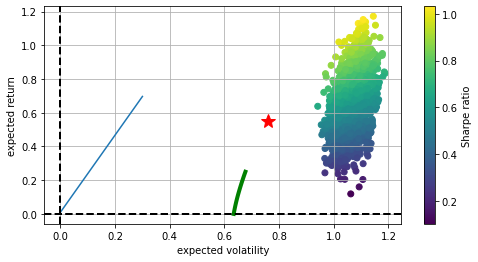

In [30]:
plt.figure(figsize=(8, 4))
plt.scatter(portfolio_volatility, portfolio_returns, c=(portfolio_returns - 0.01) / portfolio_volatility, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0) # efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [31]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - f(opt[2])}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(min_func_port, number_of_assets * [1. / number_of_assets,], method='SLSQP', bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.437, 0.   , 0.221, 0.115, 0.   , 0.   , 0.   , 0.   , 0.228,
       0.   ])